In [1]:
# !wget https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2-Audio/audio/guess_age_gender.wav

In [2]:
import os

os.environ['HF_HOME'] = '/home/husein/ssd3'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import librosa
import torch
import torch.nn as nn
import pandas as pd
from datasets import Audio
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Qwen2AudioForConditionalGeneration, AutoConfig, AutoModelForCausalLM
from streaming import MDSWriter
from streaming.base.format.mds.encodings import Encoding, _encodings
from streaming import LocalDataset
from malaysian_sft import accept
import streaming
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import json
import math

class UInt32(Encoding):
    def encode(self, obj) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes):
        return np.frombuffer(data, np.uint32)

_encodings['uint32'] = UInt32

columns = {
    'input_ids': 'uint32',
    'position_ids': 'uint32',
    'attention_mask': 'uint32',
    'audio': 'str',
    'text': 'str'
}
hashes = 'sha1', 'xxh64'

In [4]:
audio_class = Audio(sampling_rate=16000)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-Audio-7B-Instruct")
tokenizer = processor.tokenizer
audio_token = "<|AUDIO|>"
audio_bos_token = "<|audio_bos|>"
audio_eos_token = "<|audio_eos|>"
audio_token_id = processor.tokenizer._convert_token_to_id_with_added_voc('<|AUDIO|>')
pad_token_id = processor.tokenizer.pad_token_id
torch_dtype = torch.bfloat16
min_dtype = torch.finfo(torch_dtype).min
sequence_length = 4096

In [5]:
processor.feature_extractor.hop_length

160

In [6]:
data = []
for f in ['prepare-speech-instructions.json', 'prepare-transcription-instructions.json']:
    with open(f) as fopen:
        data.extend(json.load(fopen))
        
len(data)

873196

In [7]:
from datasets import Audio

def collator(batch, batch_position_ids, audio):
    input_ids = []
    position_ids = []
    masks = []
    for i in range(len(batch)):
        l = len(batch[i])
        input_ids.extend(batch[i])
        position_ids.extend(batch_position_ids[i])
        masks.append(l)
        
    input_ids = input_ids + [pad_token_id] * (sequence_length - len(input_ids))
    position_ids = position_ids + [0] * (sequence_length - len(position_ids))
    
    return {
        'input_ids': np.array(input_ids).astype(np.uint32),
        'position_ids': np.array(position_ids).astype(np.uint32),
        'attention_mask': np.array(masks).astype(np.uint32),
        'audio': json.dumps(audio),
        'text': '',
    }

def get_new_token(f, sample):

    audio_ = audio_class.decode_example(audio_class.encode_example(f))['array']

#     inputs_audio = processor.feature_extractor(
#         [audio_], 
#         return_attention_mask=True, 
#         padding="max_length", 
#         sampling_rate=16000,
#         return_tensors = 'pt'
#     )

    audio_lengths = [min(3000, math.ceil(len(audio_) / processor.feature_extractor.hop_length))]

    num_audio_tokens = sample.count(audio_token)
    replace_str = []
    while audio_token in sample:
        audio_length = audio_lengths.pop(0)
        input_length = (audio_length - 1) // 2 + 1
        num_audio_tokens = (input_length - 2) // 2 + 1

        expanded_audio_token = audio_token * num_audio_tokens

        audio_token_start_idx = sample.find(audio_token)
        audio_token_end_idx = audio_token_start_idx + len(audio_token)

        has_bos = (
            sample[audio_token_start_idx - len(audio_bos_token) : audio_token_start_idx]
            == audio_bos_token
        )
        has_eos = (
            sample[audio_token_end_idx : audio_token_end_idx + len(audio_eos_token)]
            == audio_eos_token
        )

        if not has_bos and not has_eos:
            expanded_audio_token = audio_bos_token + expanded_audio_token + audio_eos_token

        replace_str.append(expanded_audio_token)
        sample = sample.replace(audio_token, "<placeholder>", 1)

    while "<placeholder>" in sample:
        sample = sample.replace("<placeholder>", replace_str.pop(0), 1)
    
    return sample

In [14]:
!rm -rf tokenized-audio-4096
!mkdir tokenized-audio-4096

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
import time

def loop(files, block_size = sequence_length):
    rows, index = files
    out_root = f'tokenized-audio-4096/tokenized-{index}'
    os.system(f'rm -rf {out_root}')
    count = 0
    temp = []
    position_ids = []
    audio = []
    with MDSWriter(out=out_root, columns=columns, compression=None, hashes=hashes) as out:
        for row in tqdm(rows, desc=f'loop {index}'):
            try:
                prompt = get_new_token(row['audio'], row['text'])
            except Exception as e:
                print(row)
                continue
            outputs = tokenizer(prompt, add_special_tokens = False)
            length = len(outputs['input_ids'])
            if length > block_size:
                continue
            
            if count + length > block_size:
                o = collator(temp, position_ids, audio)
                out.write(o)
                temp = [outputs['input_ids']]
                position_ids = [range(len(outputs['input_ids']))]
                audio = [row['audio']]
                count = length
            
            else:
                temp.append(outputs['input_ids'])
                position_ids.append(range(len(outputs['input_ids'])))
                audio.append(row['audio'])
                count += length
        
        if len(temp):
            o = collator(temp, position_ids, audio)
            out.write(o)
    return [1]

In [12]:
loop((data[:1000], 0))

loop 0: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.45it/s]


[1]

In [16]:
from multiprocess import Pool
import mp

chunks = mp.chunks(data, 50000)
pool = Pool(10)
pooled = pool.map(loop, chunks)
pool.close()
pool.join()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'text': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHei chatbot, adakah anda mempunyai haiwan peliharaan?<|im_end|>\n<|im_start|>assistant\nTidak, saya tidak mempunyai haiwan peliharaan. Saya tidak mempunyai keupayaan fizikal, jadi saya tidak boleh mempunyai haiwan peliharaan dalam pengertian tradisional.<|im_end|>\n<|im_start|>user\nOh begitu. Bolehkah anda bermain catur dengan saya?<|im_end|>\n<|im_start|>assistant\nPasti! Saya akan gembira bermain catur dengan anda. Inilah papannya.<|im_end|>\n<|im_start|>user\nHebat! Saya akan menjadi kepingan putih. *buat tindakan haram*<|im_end|>\n<|im_start|>assistant\nSaya minta maaf, tetapi langkah itu tidak dibenarkan. Ksatria hanya boleh bergerak ke petak sama ada dua petak dalam garis lurus dan kemudian satu petak berserenjang dengan itu, atau satu petak dalam garis lurus dan kemudian dua petak berserenjang dengan itu.<|im_end|>\n<|im_start|>user\nOh betul. Saya terlupa. *buat satu lagi tindakan haram*<|i

{'text': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHei chatbot, adakah anda mempunyai haiwan peliharaan?<|im_end|>\n<|im_start|>assistant\nTidak, saya tidak mempunyai haiwan peliharaan. Saya tidak mempunyai keupayaan fizikal, jadi saya tidak boleh mempunyai haiwan peliharaan dalam pengertian tradisional.<|im_end|>\n<|im_start|>user\nOh begitu. Bolehkah anda bermain catur dengan saya?<|im_end|>\n<|im_start|>assistant\nPasti! Saya akan gembira bermain catur dengan anda. Inilah papannya.<|im_end|>\n<|im_start|>user\nHebat! Saya akan menjadi kepingan putih. *buat tindakan haram*<|im_end|>\n<|im_start|>assistant\nSaya minta maaf, tetapi langkah itu tidak dibenarkan. Ksatria hanya boleh bergerak ke petak sama ada dua petak dalam garis lurus dan kemudian satu petak berserenjang dengan itu, atau satu petak dalam garis lurus dan kemudian dua petak berserenjang dengan itu.<|im_end|>\n<|im_start|>user\nOh betul. Saya terlupa. *buat satu lagi tindakan haram*<|i

loop 1:  20%|██████████████▌                                                           | 9872/50000 [02:48<10:42, 62.43it/s]

{'text': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHei chatbot, adakah anda suka jenaka?<|im_end|>\n<|im_start|>assistant\nSaya tidak mempunyai keupayaan untuk "suka" sesuatu, tetapi saya pasti boleh memahami dan membalas jenaka. Teruskan, beritahu saya satu!<|im_end|>\n<|im_start|>user\nMengapa tomato menjadi merah?<|im_end|>\n<|im_start|>assistant\nOh, saya tahu yang ini! Ia menghabiskan terlalu banyak masa di bawah sinar matahari.<|im_end|>\n<|im_start|>user\nMengapa saintis tidak mempercayai atom?<|im_end|>\n<|im_start|>assistant\nKerana mereka membentuk segala-galanya!<|im_end|>\n<|im_start|>user\nApa yang anda panggil mi palsu?<|im_end|>\n<|im_start|>assistant\nSatu impasta!<|im_end|>\n<|im_start|>user\nMengapa anda tidak boleh memberi Elsa belon?<|im_end|>\n<|im_start|>assistant\nKerana dia akan melepaskannya!<|im_end|>\n<|im_start|>user\nKenapa orang scarecrow memenangi anugerah?<|im_end|>\n<|im_start|>assistant\nKerana dia cemerlang dalam b

loop 8:  40%|█████████████████████████████▏                                           | 19982/50000 [02:41<09:07, 54.83it/s]

{'text': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHei chatbot, adakah anda suka jenaka?<|im_end|>\n<|im_start|>assistant\nSaya tidak mempunyai keupayaan untuk "suka" sesuatu, tetapi saya pasti boleh memahami dan membalas jenaka. Teruskan, beritahu saya satu!<|im_end|>\n<|im_start|>user\nMengapa tomato menjadi merah?<|im_end|>\n<|im_start|>assistant\nOh, saya tahu yang ini! Ia menghabiskan terlalu banyak masa di bawah sinar matahari.<|im_end|>\n<|im_start|>user\nMengapa saintis tidak mempercayai atom?<|im_end|>\n<|im_start|>assistant\nKerana mereka membentuk segala-galanya!<|im_end|>\n<|im_start|>user\nApa yang anda panggil mi palsu?<|im_end|>\n<|im_start|>assistant\nSatu impasta!<|im_end|>\n<|im_start|>user\nMengapa anda tidak boleh memberi Elsa belon?<|im_end|>\n<|im_start|>assistant\nKerana dia akan melepaskannya!<|im_end|>\n<|im_start|>user\nKenapa orang scarecrow memenangi anugerah?<|im_end|>\n<|im_start|>assistant\nKerana dia cemerlang dalam b

loop 16: 100%|███████████████████████████████████████████████████████████████████████| 50000/50000 [04:30<00:00, 185.08it/s]


In [17]:
folders = glob('tokenized-audio-4096/tokenized-*') + glob('tokenized-4k/tokenized-*')
len(folders)

36

In [18]:
!rm -rf packing-4k

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
with MDSWriter(out='packing-4k', columns=columns, compression=None, hashes=hashes) as out:
    for f in folders:
        try:
            dataset = LocalDataset(local=f)
            for i in tqdm(range(len(dataset))):
                out.write(dataset[i])
        except Exception as e:
            print(e)
            pass

100%|██████████████████████████████████████████████████████████████████████████████| 18664/18664 [00:01<00:00, 12503.15it/s]


In [6]:
import torch.nn.functional as F

def block_diagonal_concat_inverted(*masks, dtype=torch.bfloat16):
    total_size = sum(mask.size(0) for mask in masks)
    combined_mask = torch.zeros(total_size, total_size, dtype=dtype)

    current_pos = 0

    for mask in masks:
        size = mask.size(0)
        combined_mask[current_pos:current_pos + size, current_pos:current_pos + size] = mask
        current_pos += size

    min_value = torch.finfo(dtype).min if dtype.is_floating_point else torch.iinfo(dtype).min
    inverted_mask = torch.where(combined_mask == 1, torch.tensor(0, dtype=dtype), min_value)
    return inverted_mask.unsqueeze(0)

def pad_attention_mask_4d(attention_mask, max_size = 4096, value = 0.0):
    maxlen_right = max_size
    maxlen_bottom = max_size
    attention_mask = [
        F.pad(
            attention_mask[i],
            (0, maxlen_right - attention_mask[i].shape[-2], 0, maxlen_bottom - attention_mask[i].shape[-1]), value = value) for i in range(
            len(attention_mask))]
    return torch.stack(attention_mask)

In [7]:
def collator(batch):
    batch = [b for b in batch if b is not None] 
    input_ids, attention_mask, position_ids, labels = [], [], [], []
    input_features, feature_attention_mask = [], []

    for b in batch:
        if 'input_features' in b:
            input_features.append(b['input_features'])
            feature_attention_mask.append(b['feature_attention_mask'])
        input_ids.append(b['input_ids'][None])
        attention_mask.append(b['attention_mask'])
        position_ids.append(b['position_ids'][None])
        labels.append(b['labels'][None])

    input_ids = {
        'input_ids': torch.concat(input_ids, 0),
        'attention_mask': pad_attention_mask_4d(attention_mask, sequence_length, min_dtype),
        'position_ids': torch.concat(position_ids, 0),
        'labels': torch.concat(labels, 0),
    }
    if len(input_features):
        input_ids['input_features'] = torch.concat(input_features, 0)
        input_ids['feature_attention_mask'] = torch.concat(feature_attention_mask, 0)

    return input_ids

In [8]:
class DatasetFixed(torch.utils.data.Dataset):
    def __init__(self, local):
        self.dataset = LocalDataset(local=local)
        self.audio = Audio(sampling_rate=16000)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        try:
            data.pop('text', None)
            audio_files = data.pop('audio', '')
            data['labels'] = data["input_ids"].copy()
            masking = data.pop('attention_mask')

            data.pop('token_type_ids', None)
            for k in data.keys():
                data[k] = torch.tensor(data[k].astype(np.int64))

            masks = []
            for m in masking:
                masks.append(torch.tril(torch.ones(m, m)))
            attention_mask = block_diagonal_concat_inverted(*masks)
            data['attention_mask'] = attention_mask

            data['labels'][data['labels'] == audio_token_id] = -100
            data['labels'][data['labels'] == pad_token_id] = -100

            if len(audio_files):
                files = json.loads(audio_files)
                print(files)
                audios = []
                for f in files:
                    audio = self.audio.decode_example(
                    self.audio.encode_example(f))['array']
                    audios.append(audio)

                inputs_audio = processor.feature_extractor(
                    audios, return_attention_mask=True, 
                    sampling_rate=16000,
                    padding="max_length", return_tensors = 'pt')

                data['input_features'] = inputs_audio['input_features']
                data['feature_attention_mask'] = inputs_audio['attention_mask']
                
            return data

        except Exception as e:
            print('Exception', e)
            return None

    def __len__(self):
        return len(self.dataset)

In [9]:
dataset = DatasetFixed('packing-4k')

In [30]:
dataset[10000]

['/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-7/15027.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-13/5750.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-3/4401.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-8/184.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-6/5657.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-8/28071.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-2/16132.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-0/20140.mp3', '/home/husein/ssd3/dataset/speech-instructions/short-coding-2/1548.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-12/5325.mp3', '/home/husein/ssd3/dataset/speech-instructions/partition-instructions-part-5/8491.mp3']


{'input_ids': tensor([151644,   8948,    198,  ..., 151643, 151643, 151643]),
 'position_ids': tensor([0, 1, 2,  ..., 0, 0, 0]),
 'labels': tensor([151644,   8948,    198,  ...,   -100,   -100,   -100]),
 'attention_mask': tensor([[[ 0.0000e+00, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          ...,
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ...,  0.0000e+00,
           -3.3895e+38, -3.3895e+38],
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ...,  0.0000e+00,
            0.0000e+00, -3.3895e+38],
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]], dtype=torch.bfloat16),
 'input_features': tensor([[[-0.5321, -0.5411, -0.5411,  ..., -0.5411, -0.5411, -0.5411],
      

In [44]:
batch = [dataset[0], dataset[200000]]

['/home/husein/ssd3/dialects_processed/BENGKEL KERJA PSS [rRzOjoBmYwc]/BENGKEL KERJA PSS [rRzOjoBmYwc]_461.mp3', '/home/husein/ssd3/dialects_processed/ADUHH DIWAN SUNAT DI BULAN PUASA KERNA LAPAR [ddxxMnFMuAk]/ADUHH DIWAN SUNAT DI BULAN PUASA KERNA LAPAR [ddxxMnFMuAk]_2.mp3', '/home/husein/ssd3/dialects_processed/[[LIVE]]6.10.22 Bubar Parlimen tak jadi？ Anak menteri & SPH [xGLhHBXxPAk]/[[LIVE]]6.10.22 Bubar Parlimen tak jadi？ Anak menteri & SPH [xGLhHBXxPAk]_239.mp3', '/home/husein/ssd3/dialects_processed/Pertandingan Pidato Sektor Awam Piala Setiausaha Kerajaan Terengganu 2024 [wkoNBavuJW0]/Pertandingan Pidato Sektor Awam Piala Setiausaha Kerajaan Terengganu 2024 [wkoNBavuJW0]_50.mp3', '/home/husein/ssd3/dialects_processed/Pertandingan Pidato dan Majlis Perasmian Penutupan Program Saya Remaja Malaysia [N6EiCeVnkxY]/Pertandingan Pidato dan Majlis Perasmian Penutupan Program Saya Remaja Malaysia [N6EiCeVnkxY]_97.mp3', '/home/husein/ssd3/dialects_processed/LUAR BIASA!! BULE LUCU YANG FAS

In [45]:
b = collator(batch)
b['feature_attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)

In [46]:
b['attention_mask']

tensor([[[[ 0.0000e+00, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          ...,
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [-3.3895e+38, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38]]],


        [[[ 0.0000e+00, -3.3895e+38, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00, -3.3895e+38,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3895e+38,
           -3.3895e+38, -3.3895e+38],
          ...,
   

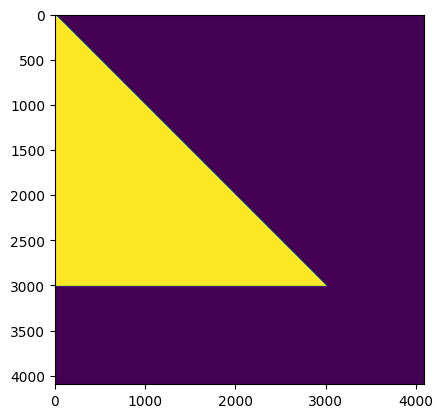

In [47]:
import matplotlib.pyplot as plt

plt.imshow(b['attention_mask'][1, 0].float().numpy())

In [49]:
tokenizer.decode(b['input_ids'][1])

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nAudio 1: <|audio_bos|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|><|AUDIO|

In [49]:
!du -hs packing-4k

13G	packing-4k


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
from huggingface_hub import HfApi
api = HfApi()

api.upload_folder(
    folder_path="packing-4k",
    repo_id="huseinzol05/malaysian-audio-instructions",
    repo_type="dataset",
)